In [12]:
from dotenv import load_dotenv

load_dotenv('.env-db')
from utils.utils import get_database
from transformers import LlamaTokenizerFast
tokenizer = LlamaTokenizerFast.from_pretrained('hf-internal-testing/llama-tokenizer')
import pandas as pd
def count_tokens(prompt):
    return len(tokenizer.tokenize(prompt))

## Copy existing reference DB to new one

In [15]:
db = get_database()
llm_name = 'OpenAssistant/llama2-13b-orca-8k-3319'
# llm_name = openchat/openchat_v3.1
# llm_name = 'baichuan-inc/Baichuan-13B-Base'
dim = 'contrast'
# all_ratings_llm = pd.DataFrame(list(db[f'queries/{llm_name}/{dim}'].find({})))
# all_ratings_llm = pd.DataFrame(list(db[f'queries/{dim}/{llm_name}'].find({})))

In [11]:
####### WARNING: THIS WILL REPLACE ALL QUERIES IN THE COLLECTION ####################
######## reference_queries = list(db[f'queries/reference/{dim}'].find({})) ##########
####### db[f'queries/{llm_name}/{dim}'].insert_many(reference_queries) ###########
# db.collection.create_index([(<key and index type specification>)], <options> )

In [16]:
db[f'queries/{llm_name}/{dim}'].update_many({"rating": -100}, {"$set": {'rating': -1}})

In [36]:
# len(all_queries)
import requests
requests.post("http://localhost:8000/calibrations/cleanup", data="{}")

ConnectionError: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /calibrations/cleanup (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x299e9c4c0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [98]:
# db[f'queries/{llm_name}/{dim}'].insert_many(all_queries)

Average latency: 0.38991114346218436


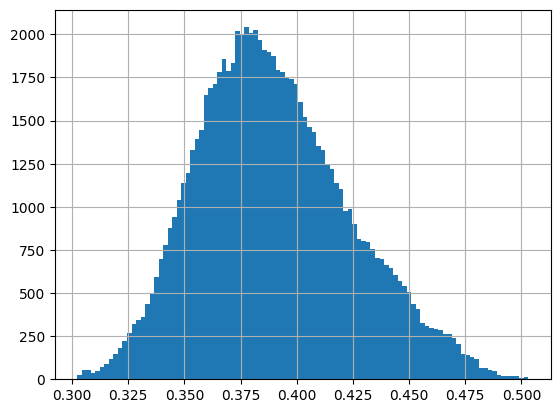

In [10]:
# get average latency
latencies = list(db[f'queries/{llm_name}/{dim}'].find({"latency":{"$gt":0}}))
latencies = pd.DataFrame(latencies)
latencies['latency'].hist(bins=100)
print(f"Average latency: {sum(latencies['latency'])/len(latencies['latency'])}")

<Axes: >

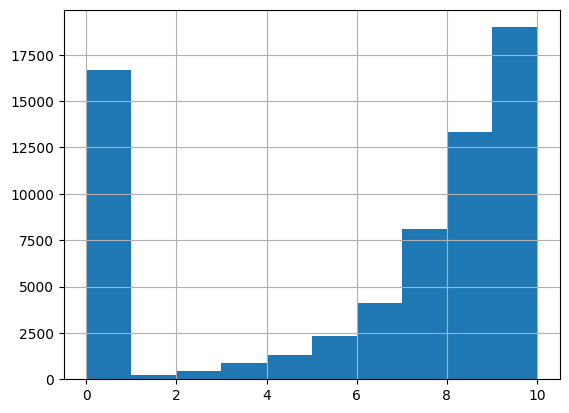

In [21]:
latencies['rating'] = latencies['rating'].astype(int)
latencies[(0 <= latencies['rating']) & (latencies['rating'] <= 10)]['rating'].hist(bins=10)

In [8]:
db[f'queries/{llm_name}/{dim}'].update_many({"latency":{"$gt":0}, "rating": -1}, {"$set": {"latency": -1, "num_tries": 0}})

In [ ]:
count_tokens('10')

In [ ]:
# import tqdm
# # display dist. of prompt lengths
# dim = 'contrast'
# prefixes = {prefix['prefix_index']:prefix for prefix in list(db['prefixes'].find({}))}
# prompts = {prompt['prompt_index']:prompt for prompt in list(db[f'core_prompts/{dim}'].find({}))}
# samples = {sample['sample_index']:sample for sample in list(db[f'samples/{dim}'].find({}))}
# tokens_dist = []
# prefix = max(prefixes.values(), key=lambda x : len(x['prefix']))
# for prompt in tqdm.tqdm(prompts):
#     for sample in samples:
#         t = count_tokens(prefix['prefix'] + prompts[prompt]['combined_prompt'] + samples[sample]['sample'])
#         tokens_dist.append(t)
# pd.Series(tokens_dist).hist(bins=100)

In [13]:
import tqdm
skip_prefix_severe = ['reciprocity', 'unity', 'scarcity']
for dim in ['authority']:
    query_docs = []
    print("UPLOADING DIMENSION", dim)
    all_dim_prompts = list(db[f'core_prompts/{dim}'].find({}))
    all_dim_samples = list(db[f'samples/{dim}'].find({}))
    all_prefixes = list(db[f'prefixes'].find({}))
    for prefix_doc in tqdm.tqdm(all_prefixes):
        prefix_ind = prefix_doc['prefix_index']
        if prefix_ind == 2 and dim in skip_prefix_severe:
            continue
        for prompt_doc in all_dim_prompts:
            for sample_doc in all_dim_samples:
                query_doc = {
                    'prefix_index': prefix_doc['prefix_index'],
                    'prompt_index': prompt_doc['prompt_index'],
                    'sample_index': sample_doc['sample_index'],
                    'dimension': dim,
                    'latency': -1.0,
                    'num_tries': 0,
                    'rating': -1,
                }
                query_docs.append(query_doc)

UPLOADING DIMENSION authority


100%|██████████| 6/6 [00:00<00:00, 35.62it/s]


In [2]:
import pandas as pd
c = pd.Series([3, 4, 5])

In [5]:
c.replace(list(range(3, 5)), 10)

0    10
1    10
2     5
dtype: int64